In [1]:
import os
import sys


import numpy as np
import pandas as pd
import torch

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
BASE_DIR = ".."
MODEL_BASE_DIR = f"{BASE_DIR}/best_models"
DATA_DIR = f"{BASE_DIR}/nbdata"
os.makedirs(MODEL_BASE_DIR,exist_ok=True)
os.makedirs(DATA_DIR,exist_ok=True)
sys.path.append(BASE_DIR)

In [3]:
import captum
captum.__version__

'0.4.0'

In [4]:
from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)

from src.featurizers import (
    MorganFeaturizer,
    ProtBertFeaturizer,
    ProseFeaturizer,
    BindPredict21Featurizer,
    DSCRIPTFeaturizer,
    ConcatFeaturizer
)

from src.architectures import SimpleCoembedding
from src.utils import set_random_seed

---

In [266]:
# Load model
device = torch.device(6)
drug_featurizer = MorganFeaturizer().cuda(device)
target_featurizer = ProtBertFeaturizer(per_tok = True).cuda(device)
model = SimpleCoembedding(drug_featurizer.shape, target_featurizer.shape, 1024)
model.load_state_dict(torch.load("../best_models/ProdModels/prod_within_state.pt"))
model = model.eval()
model = model.to(device)

In [6]:
set_random_seed(61998)

In [7]:
task_dir = "../dataset/DAVIS/"

In [8]:
df = pd.read_csv(f"{task_dir}/test.csv",index_col=0)
# df = pd.read_csv(f'{BASE_DIR}/dataset/BindingDB/test.csv',index_col=0)

In [9]:
# drug_featurizer.preload(df['SMILES'].unique())
# target_featurizer.preload(df['Target Sequence'].unique())

ProtBert: 100%|███████████████████████████████████████████████████████████████████| 379/379 [00:00<00:00, 3242.96it/s]


In [17]:
# baseline_drug = torch.zeros(drug_featurizer.shape).unsqueeze(0).cuda(device)
# baseline_prot = torch.zeros(target_featurizer.shape).unsqueeze(0).to(device)

In [9]:
sample_drug = df['SMILES'][0]
sample_target = df['Target Sequence'][0]

In [104]:
from tqdm.notebook import tqdm

In [305]:
class ModelWrapper(nn.Module):
    def __init__(self, model, debug=False):
        super().__init__()
        
        self.model = model
        self.debug = debug
  
    def forward(self, de, te):
        if self.debug: print('de is', de.shape)
        if self.debug: print('te is', te.shape)
        
        te = te.mean(1)
        if self.debug: print('te is', te.shape)
        
        return self.model(de, te)

In [311]:
mw = ModelWrapper(model, debug=False).cuda(device)
ig = DeepLift(mw)

In [315]:
ytrue = []
phat = []

for _, r in tqdm(df.sample(100).iterrows(),total=100):
    l = r.Label
    de = drug_featurizer(r['SMILES']).unsqueeze(0)
    te = target_featurizer(r['Target Sequence']).unsqueeze(0)
    ph = mw(de, te)
    ytrue.append(l)
    phat.append(ph.item())
    
from sklearn.metrics import average_precision_score
print(average_precision_score(ytrue, phat))

  0%|          | 0/100 [00:00<?, ?it/s]

0.7549108734402852


In [329]:
prot_attr.shape

torch.Size([1, 505, 1024])

torch.Size([1, 552, 1024])

In [347]:
prot_attr.shape

torch.Size([1, 552, 1024])

In [355]:
dfpos = df[df['Label'] == 1]

In [367]:
dfpos.head(10)[['SMILES', 'Target Sequence']].iloc[0].values

array(['CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C)NC4=NC(=CS4)C5=CN=CC=C5',
       'MGPEALSSLLLLLLVASGDADMKGHFDPAKCRYALGMQDRTIPDSDISASSSWSDSTAARHSRLESSDGDGAWCPAGSVFPKEEEYLQVDLQRLHLVALVGTQGRHAGGLGKEFSRSYRLRYSRDGRRWMGWKDRWGQEVISGNEDPEGVVLKDLGPPMVARLVRFYPRADRVMSVCLRVELYGCLWRDGLLSYTAPVGQTMYLSEAVYLNDSTYDGHTVGGLQYGGLGQLADGVVGLDDFRKSQELRVWPGYDYVGWSNHSFSSGYVEMEFEFDRLRAFQAMQVHCNNMHTLGARLPGGVECRFRRGPAMAWEGEPMRHNLGGNLGDPRARAVSVPLGGRVARFLQCRFLFAGPWLLFSEISFISDVVNNSSPALGGTFPPAPWWPPGPPPTNFSSLELEPRGQQPVAKAEGSPTAILIGCLVAIILLLLLIIALMLWRLHWRRLLSKAERRVLEEELTVHLSVPGDTILINNRPGPREPPPYQEPRPRGNPPHSAPCVPNGSALLLSNPAYRLLLATYARPPRGPGPPTPAWAKPTNTQAYSGDYMEPEKPGAPLLPPPPQNSVPHYAEADIVTLQGVTGGNTYAVPALPPGAVGDGPPRVDFPRSRLRFKEKLGEGQFGEVHLCEVDSPQDLVSLDFPLNVRKGHPLLVAVKILRPDATKNARNDFLKEVKIMSRLKDPNIIRLLGVCVQDDPLCMITDYMENGDLNQFLSAHQLEDKAAEGAPGDGQAAQGPTISYPMLLHVAAQIASGMRYLATLNFVHRDLATRNCLVGENFTIKIADFGMSRNLYAGDYYRVQGRAVLPIRWMAWECILMGKFTTASDVWAFGVTLWEVLMLCRAQPFGQLTDEQVIENAGEFFRDQGRQVYLSRPPACPQGLYELMLRCWSRESEQRPPFSQLHRFLAEDALN

In [356]:
pattr = []
for (_, r) in tqdm(dfpos.sample(10).iterrows(),total=10):
    mol_lift = drug_featurizer(r['SMILES']).unsqueeze(0)
    prot_lift = target_featurizer(r['Target Sequence']).unsqueeze(0)
    base_de = torch.zeros(mol_lift.shape).cuda(device)
    base_te = torch.zeros(prot_lift.shape).cuda(device)
    mol_attr, prot_attr = ig.attribute((mol_lift, prot_lift), baselines=((base_de, base_te)))
    assert prot_lift.shape[1] == prot_attr.shape[1]
    pattr.append((r['Target Sequence'], prot_attr.detach().cpu().numpy().mean(2).squeeze()))

  0%|          | 0/10 [00:00<?, ?it/s]

/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 1 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/captum/attr/_core/deep_lift.py:325: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""


In [370]:
len(r["Target Sequence"])

976

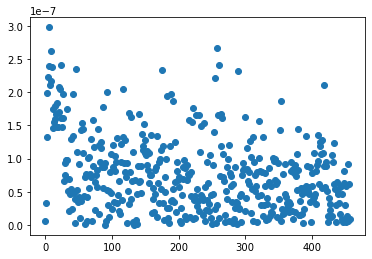

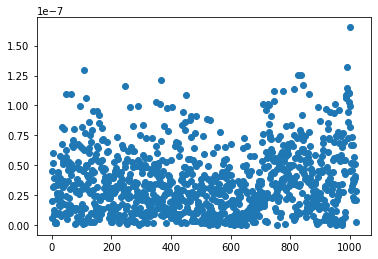

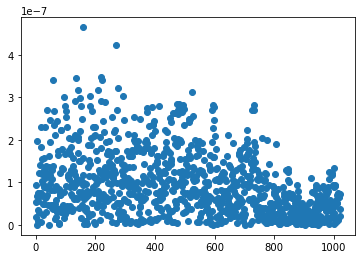

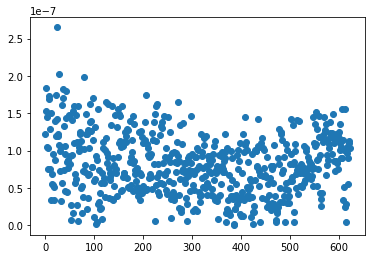

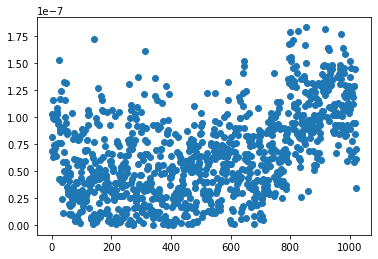

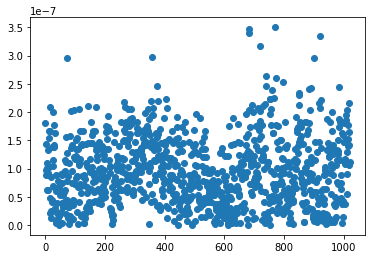

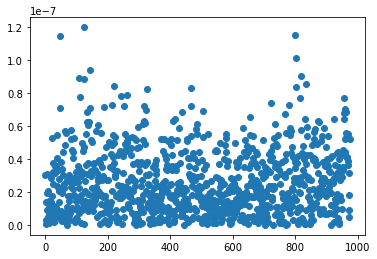

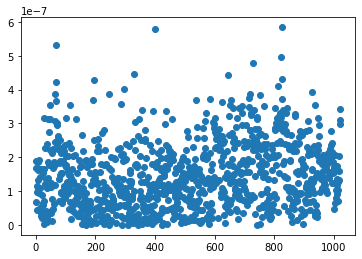

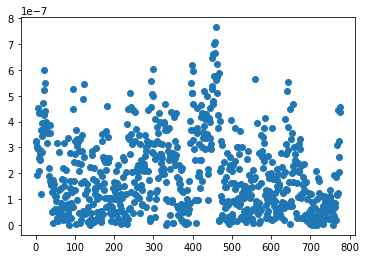

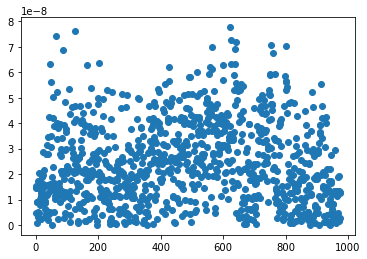

In [363]:
for ps, pa in pattr:
    plt.scatter(np.arange(len(pa)), np.abs(pa))
    plt.show()

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
prot_attr = torch.stack(pattr,0).mean(dim=0).detach().cpu()

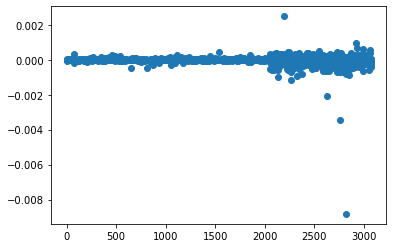

In [48]:
plt.scatter(np.arange(drug_featurizer.shape + target_featurizer.shape), prot_attr)
plt.show()

In [49]:
# attr_trans = torch.softmax(prot_attr,0).unsqueeze(0)
attr_trans = prot_attr.unsqueeze(0)

In [50]:
last_size = 1024


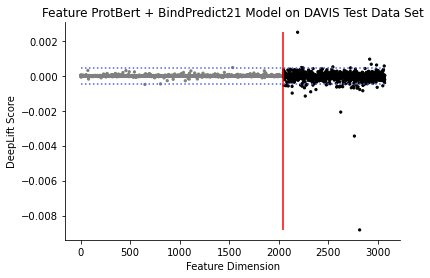

In [53]:
plt.scatter(np.arange(drug_featurizer.shape + target_featurizer.shape), attr_trans,s=5,color=['gray' for i in range(drug_featurizer.shape)]+['black' for i in range(target_featurizer.shape)])
plt.vlines(drug_featurizer.shape,attr_trans.min(), attr_trans.max(),color='r')
plt.hlines(attr_trans.mean() + 2*attr_trans.std(),0,drug_featurizer.shape + target_featurizer.shape,color='royalblue',linestyles='dotted')
plt.hlines(attr_trans.mean() - 2*attr_trans.std(),0,drug_featurizer.shape + target_featurizer.shape,color='royalblue',linestyles='dotted')
plt.xlabel('Feature Dimension')
plt.ylabel('DeepLift Score')
plt.title('Feature ProtBert + BindPredict21 Model on DAVIS Test Data Set')
sns.despine()
# plt.savefig('esm_dscript_cat_bindingdb_deeplift_attributions.svg')
plt.show()